In [1]:
import numpy as np
import os
import pandas as pd
import h5py
import seaborn as sns
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from toolbox.utils import set_random_seed
from toolbox.plt_utils import density_scatter

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [3]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
# for TF To find gpu
os.environ["LD_LIBRARY_PATH"] = f"{os.environ['CONDA_PREFIX']}/lib:" + os.environ.get("LD_LIBRARY_PATH", "")

In [4]:
# set random seed for reproducibility
set_random_seed(seed=42)

2026-01-27 17:47:04.295247: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/valehvpa/miniconda3/envs/hist6/lib:/usr/local/cuda/lib64:/usr/local/cuda/lib64
2026-01-27 17:47:04.295274: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TensorFlow not installed, skipping tf seeding.


/home/valehvpa/miniconda3/envs/hist6/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 42


# Chip-control correlation fro a represive mark

## H3K27me3

see process_encode_chip.sh. NOt doing this yet https://github.com/kundajelab/bpnet/wiki/Outlier_removal

In [5]:
# use the narrow peaks from encode (not removing outliers per https://github.com/kundajelab/bpnet/wiki/Outlier_removal)
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/gm12878_h3k27me3/ENCFF291DHI.bed.gz"
inputc_minus = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/gm12878_h3k27me3/processed/control_minus.bw"
inputc_plus = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/gm12878_h3k27me3/processed/control_plus.bw"
chip_minus = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/gm12878_h3k27me3/processed/minus.bw"
chip_plus = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/gm12878_h3k27me3/processed/plus.bw"
df = pd.read_csv(
    p,
    sep="\t",
    header=None,
    index_col=False,
)
df["length"] = df[2] - df[1]
df.rename(columns={0: 'chrom', 1: 'start', 2: 'end'}, inplace=True)

import pyBigWig
chip_minus_bw = pyBigWig.open(chip_minus)
chip_plus_bw = pyBigWig.open(chip_plus)
inputc_minus_bw = pyBigWig.open(inputc_minus)
inputc_plus_bw = pyBigWig.open(inputc_plus)
def get_cts(
    peaks_df,
    bw,
    width,
    get_total_cts: bool = False,
):
    vals = []

    for _, r in peaks_df.iterrows():
        # w = r['length'] if width is None else width
        if not get_total_cts:
            vals.append(
                np.nan_to_num(bw.values(r['chrom'],
                                        r['start'],
                                        r['end']))
            )
        else:
            vals.append(np.array([
                np.nansum(bw.values(r['chrom'],
                                    r['start'],
                                    r['end']))
            ]))

    return vals

chip_minus_cts = get_cts(df, chip_minus_bw, None, get_total_cts=True)
chip_plus_cts = get_cts(df, chip_plus_bw, None, get_total_cts=True)
inputc_minus_cts = get_cts(df, inputc_minus_bw, None, get_total_cts=True)
inputc_plus_cts = get_cts(df, inputc_plus_bw, None, get_total_cts=True)

chip_minus_cts = np.array([v[0] for v in chip_minus_cts]).squeeze()
chip_plus_cts = np.array([v[0] for v in chip_plus_cts]).squeeze()
inputc_minus_cts = np.array([v[0] for v in inputc_minus_cts]).squeeze()
inputc_plus_cts = np.array([v[0] for v in inputc_plus_cts]).squeeze()

# pool
chip_cts = chip_minus_cts + chip_plus_cts
inputc_cts = inputc_minus_cts + inputc_plus_cts

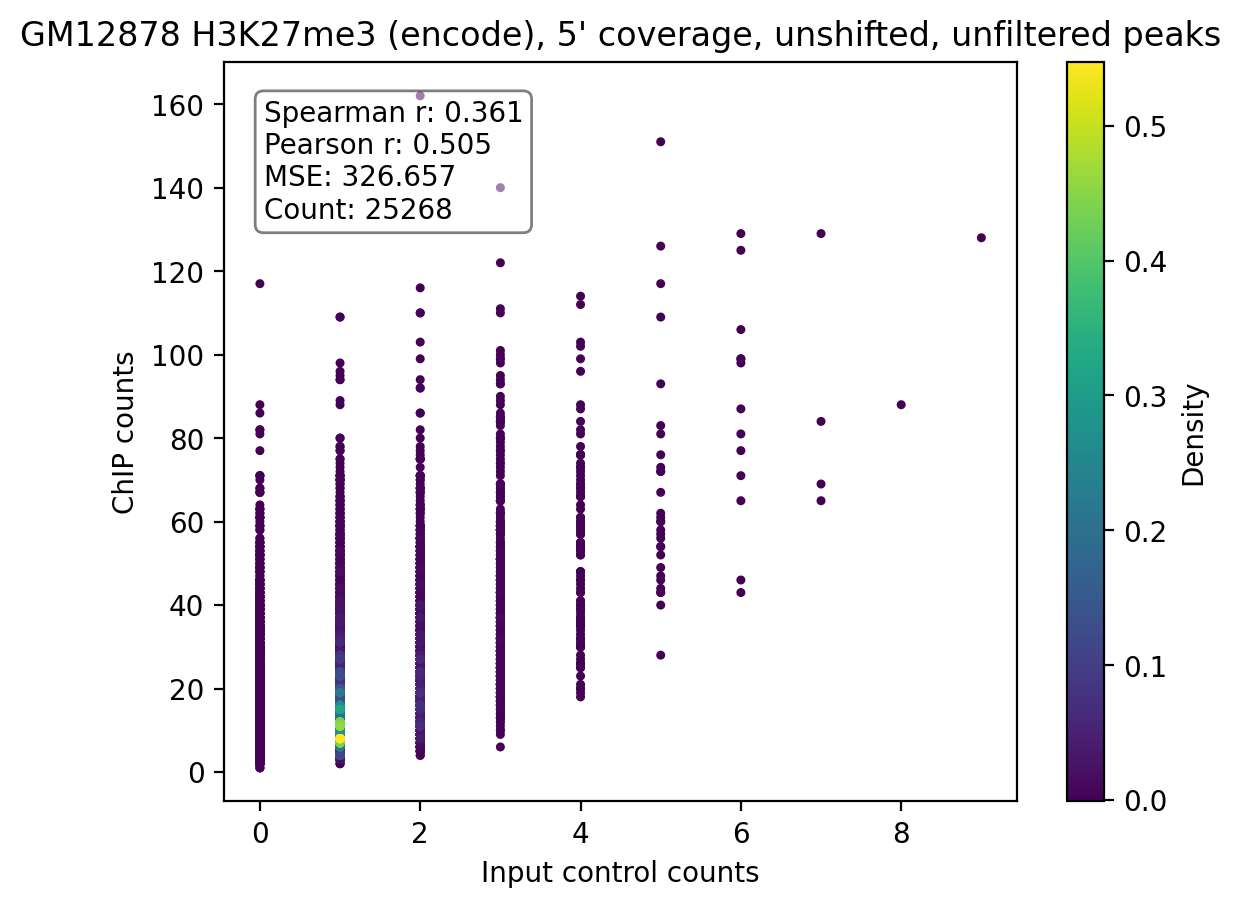

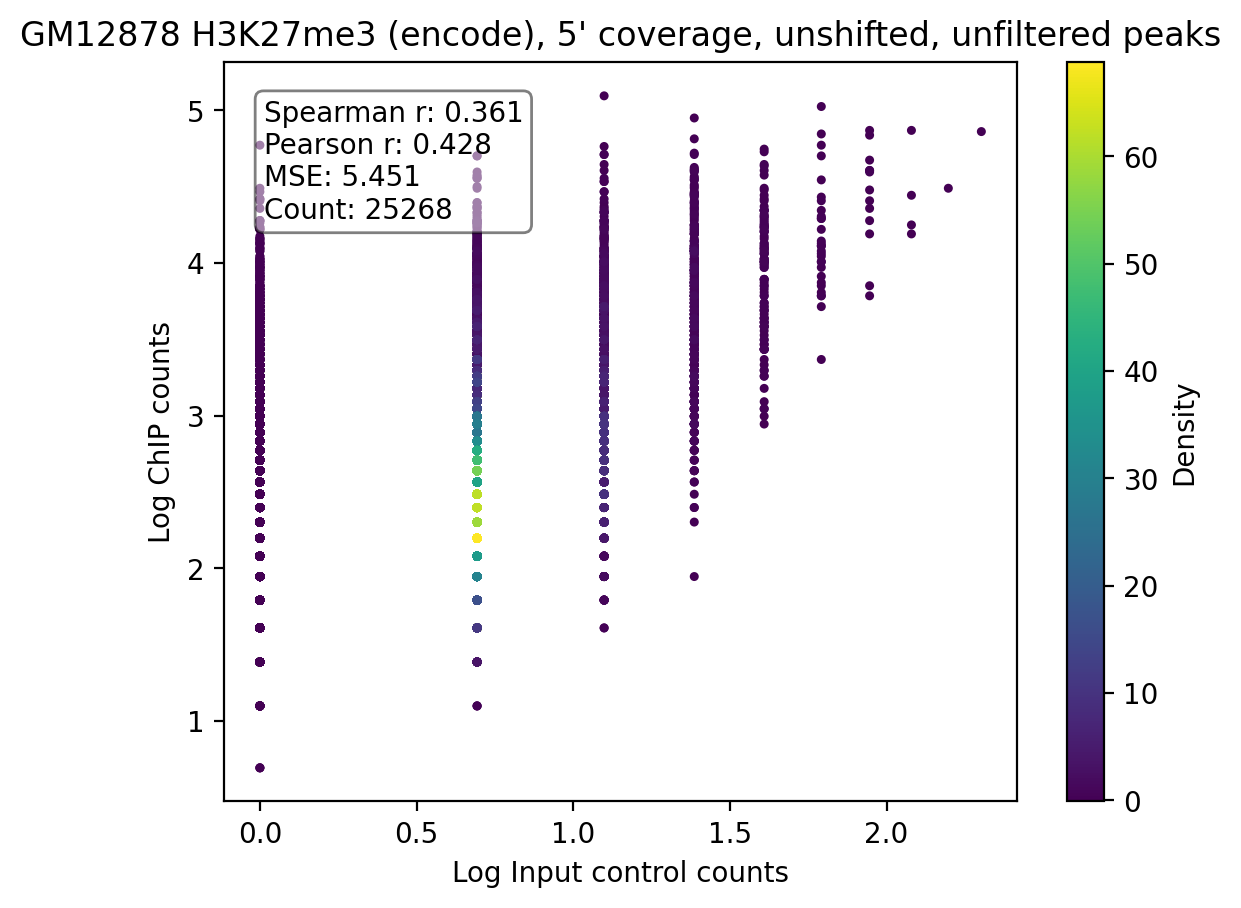

In [6]:
# plot chip_cts vs inputc_cts
density_scatter(inputc_cts, chip_cts, "Input control counts", "ChIP counts", s=5, bins=200, incl_stats=True) 
plt.title("GM12878 H3K27me3 (encode), 5' coverage, unshifted, unfiltered peaks")
plt.show()

# plot log chip_cts vs log inputc_cts
density_scatter(np.log1p(inputc_cts), np.log1p(chip_cts), "Log Input control counts", "Log ChIP counts", s=5, bins=200, incl_stats=True) 
plt.title("GM12878 H3K27me3 (encode), 5' coverage, unshifted, unfiltered peaks")
plt.show()

Now with filtered peaks

In [7]:

p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/gm12878_h3k27me3/processed/peak_outlier_removal/peaks_inliers.bed"
inputc_minus = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/gm12878_h3k27me3/processed/control_minus.bw"
inputc_plus = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/gm12878_h3k27me3/processed/control_plus.bw"
chip_minus = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/gm12878_h3k27me3/processed/minus.bw"
chip_plus = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/gm12878_h3k27me3/processed/plus.bw"

df = pd.read_csv(
    p,
    sep="\t",
    header=None,
    index_col=False,
)
df["length"] = df[2] - df[1]
df.rename(columns={0: 'chrom', 1: 'start', 2: 'end'}, inplace=True)

import pyBigWig
chip_minus_bw = pyBigWig.open(chip_minus)
chip_plus_bw = pyBigWig.open(chip_plus)
inputc_minus_bw = pyBigWig.open(inputc_minus)
inputc_plus_bw = pyBigWig.open(inputc_plus)
def get_cts(
    peaks_df,
    bw,
    width,
    get_total_cts: bool = False,
):
    vals = []

    for _, r in peaks_df.iterrows():
        # w = r['length'] if width is None else width
        if not get_total_cts:
            vals.append(
                np.nan_to_num(bw.values(r['chrom'],
                                        r['start'],
                                        r['end']))
            )
        else:
            vals.append(np.array([
                np.nansum(bw.values(r['chrom'],
                                    r['start'],
                                    r['end']))
            ]))

    return vals

chip_minus_cts = get_cts(df, chip_minus_bw, None, get_total_cts=True)
chip_plus_cts = get_cts(df, chip_plus_bw, None, get_total_cts=True)
inputc_minus_cts = get_cts(df, inputc_minus_bw, None, get_total_cts=True)
inputc_plus_cts = get_cts(df, inputc_plus_bw, None, get_total_cts=True)

chip_minus_cts = np.array([v[0] for v in chip_minus_cts]).squeeze()
chip_plus_cts = np.array([v[0] for v in chip_plus_cts]).squeeze()
inputc_minus_cts = np.array([v[0] for v in inputc_minus_cts]).squeeze()
inputc_plus_cts = np.array([v[0] for v in inputc_plus_cts]).squeeze()

# pool
chip_cts = chip_minus_cts + chip_plus_cts
inputc_cts = inputc_minus_cts + inputc_plus_cts

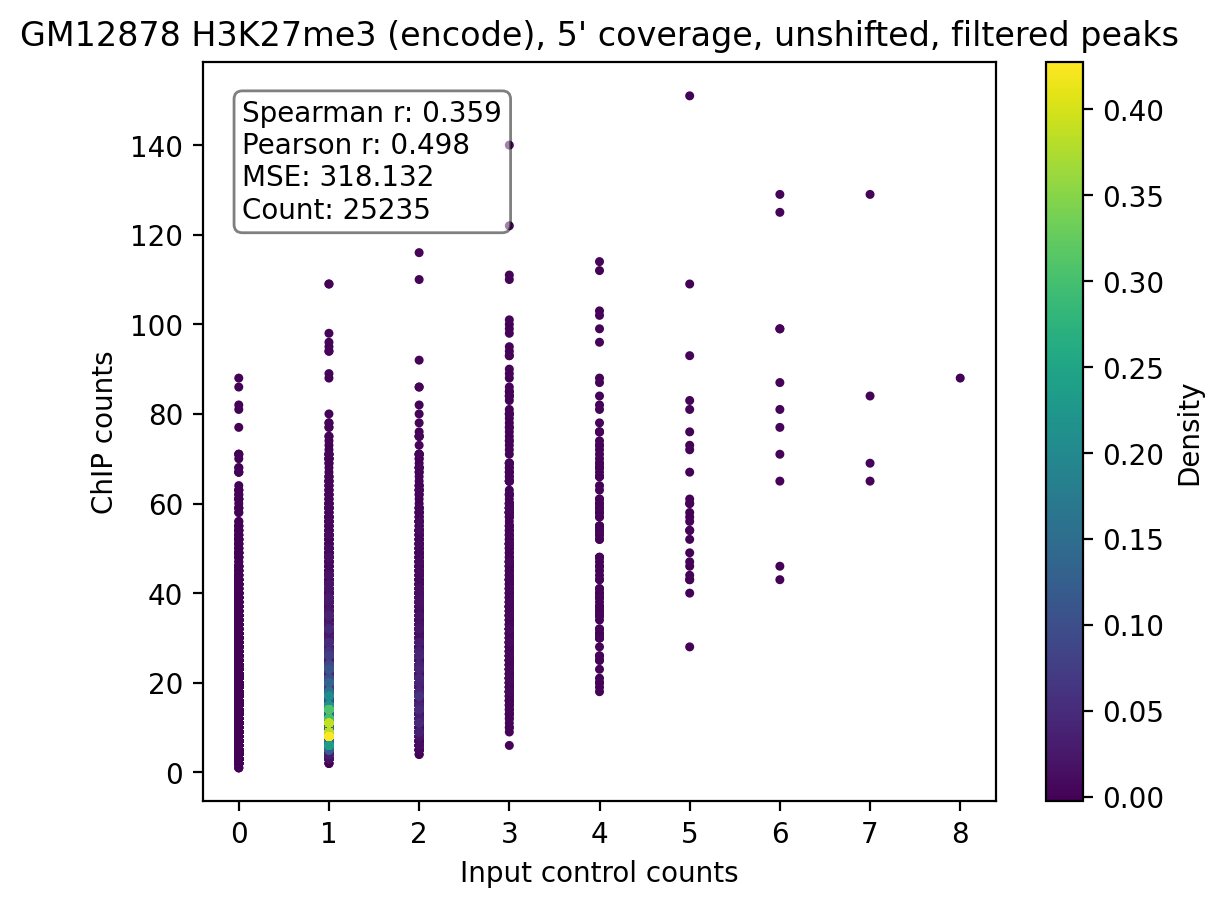

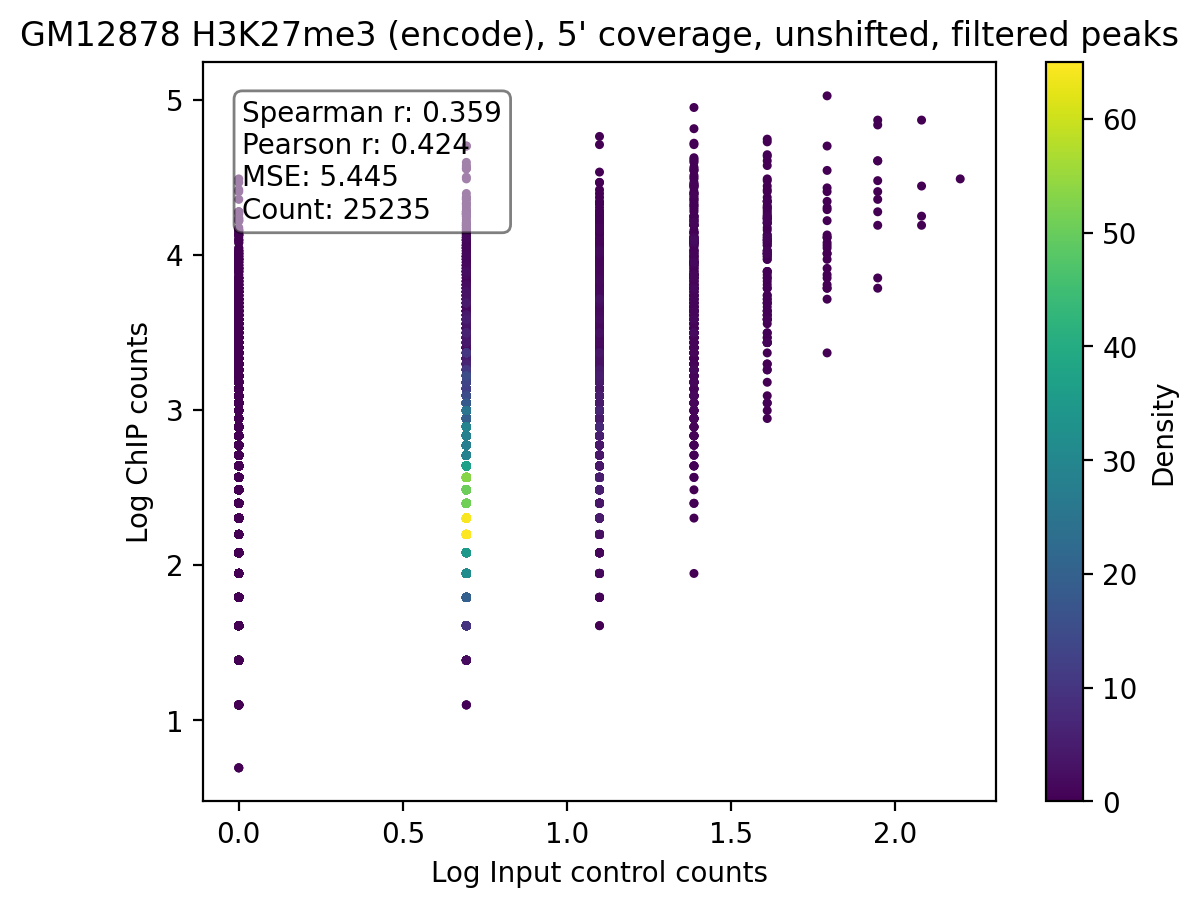

In [9]:
# plot chip_cts vs inputc_cts
density_scatter(inputc_cts, chip_cts, "Input control counts", "ChIP counts", s=5, bins=200, incl_stats=True) 
plt.title("GM12878 H3K27me3 (encode), 5' coverage, unshifted, filtered peaks")
plt.show()

# plot log chip_cts vs log inputc_cts
density_scatter(np.log1p(inputc_cts), np.log1p(chip_cts), "Log Input control counts", "Log ChIP counts", s=5, bins=200, incl_stats=True) 
plt.title("GM12878 H3K27me3 (encode), 5' coverage, unshifted, filtered peaks")
plt.show()

## H3K27me3 another one

in case the read depths were too low in the case above

In [10]:
# use the narrow peaks from encode (not removing outliers per https://github.com/kundajelab/bpnet/wiki/Outlier_removal)
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/gm12878_h3k27me3_2/ENCFF695ETB.bed.gz"
inputc_minus = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/gm12878_h3k27me3_2/processed/control_minus.bw"
inputc_plus = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/gm12878_h3k27me3_2/processed/control_plus.bw"
chip_minus = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/gm12878_h3k27me3_2/processed/minus.bw"
chip_plus = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/gm12878_h3k27me3_2/processed/plus.bw"
df = pd.read_csv(
    p,
    sep="\t",
    header=None,
    index_col=False,
)
df["length"] = df[2] - df[1]
df.rename(columns={0: 'chrom', 1: 'start', 2: 'end'}, inplace=True)

import pyBigWig
chip_minus_bw = pyBigWig.open(chip_minus)
chip_plus_bw = pyBigWig.open(chip_plus)
inputc_minus_bw = pyBigWig.open(inputc_minus)
inputc_plus_bw = pyBigWig.open(inputc_plus)
def get_cts(
    peaks_df,
    bw,
    width,
    get_total_cts: bool = False,
):
    vals = []

    for _, r in peaks_df.iterrows():
        # w = r['length'] if width is None else width
        if not get_total_cts:
            vals.append(
                np.nan_to_num(bw.values(r['chrom'],
                                        r['start'],
                                        r['end']))
            )
        else:
            vals.append(np.array([
                np.nansum(bw.values(r['chrom'],
                                    r['start'],
                                    r['end']))
            ]))

    return vals

chip_minus_cts = get_cts(df, chip_minus_bw, None, get_total_cts=True)
chip_plus_cts = get_cts(df, chip_plus_bw, None, get_total_cts=True)
inputc_minus_cts = get_cts(df, inputc_minus_bw, None, get_total_cts=True)
inputc_plus_cts = get_cts(df, inputc_plus_bw, None, get_total_cts=True)

chip_minus_cts = np.array([v[0] for v in chip_minus_cts]).squeeze()
chip_plus_cts = np.array([v[0] for v in chip_plus_cts]).squeeze()
inputc_minus_cts = np.array([v[0] for v in inputc_minus_cts]).squeeze()
inputc_plus_cts = np.array([v[0] for v in inputc_plus_cts]).squeeze()

# pool
chip_cts = chip_minus_cts + chip_plus_cts
inputc_cts = inputc_minus_cts + inputc_plus_cts

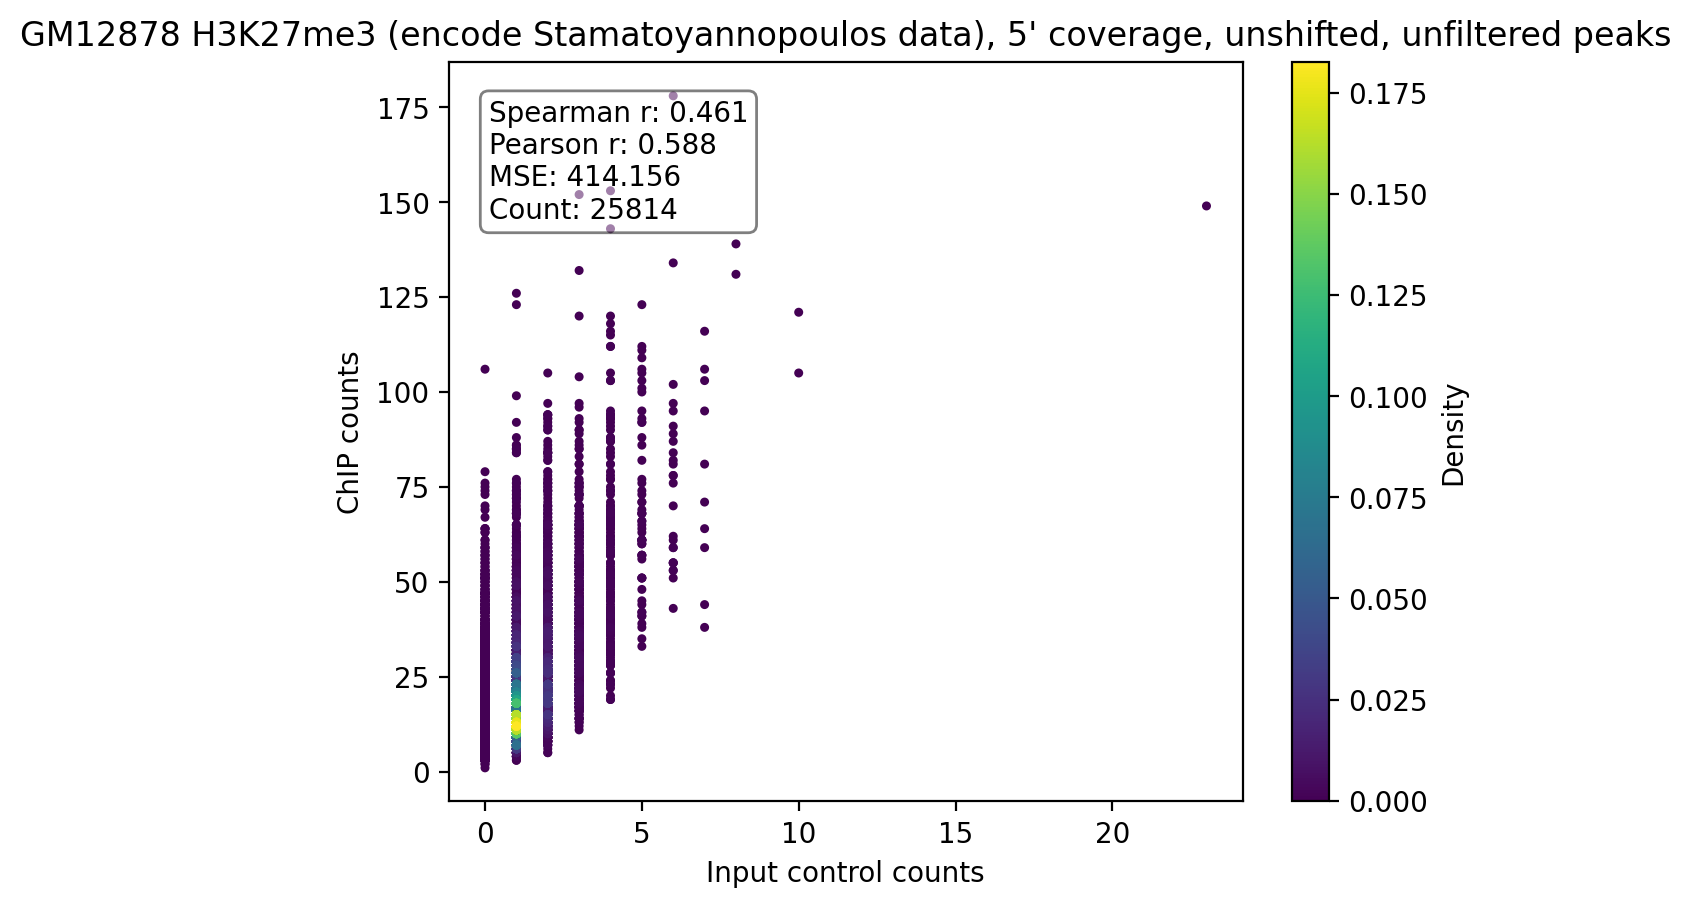

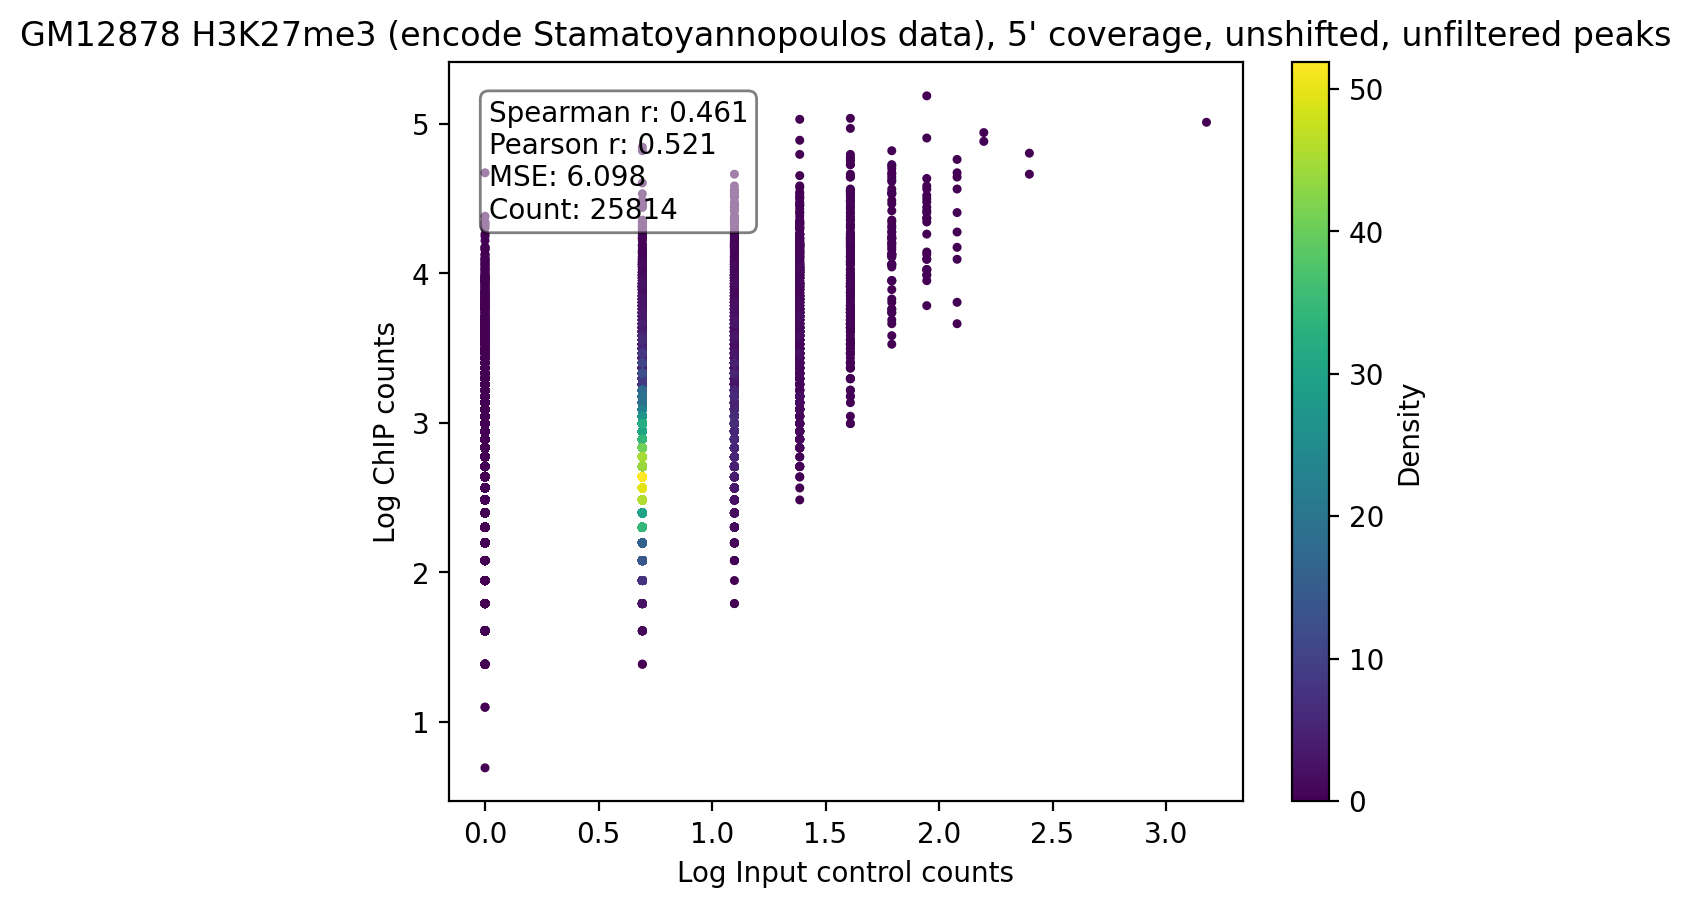

In [11]:
# plot chip_cts vs inputc_cts
density_scatter(inputc_cts, chip_cts, "Input control counts", "ChIP counts", s=5, bins=200, incl_stats=True) 
plt.title("GM12878 H3K27me3 (encode Stamatoyannopoulos data), 5' coverage, unshifted, unfiltered peaks")
plt.show()

# plot log chip_cts vs log inputc_cts
density_scatter(np.log1p(inputc_cts), np.log1p(chip_cts), "Log Input control counts", "Log ChIP counts", s=5, bins=200, incl_stats=True) 
plt.title("GM12878 H3K27me3 (encode Stamatoyannopoulos data), 5' coverage, unshifted, unfiltered peaks")
plt.show()